In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate, cross_val_score, train_test_split

from bikesharing.ml_logic.model import get_folds, train_test_indices
from bikesharing.interface.main import *

In [2]:
preprocess()


Preprocessing Data...

Load rental_data from local CSV...


/Users/azetxxx/Documents/Obsidian_Vault/Le_Wagon/08_week_wagon/group_project/shoefer987/bike_sharing_demand/bikesharing/ml_logic/data.py:33: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(cache_path, header='infer' if data_has_header else None)


✅ Data loaded, with shape (2804147, 10)

Load weather_data from local CSV...
✅ Data loaded, with shape (35064, 6)
✅ X_processed, with shape (35064, 11)


(       temperature_2m  relativehumidity_2m  apparent_temperature  \
 0            0.355408             1.000000              0.342007   
 1            0.357616             0.987013              0.340149   
 2            0.359823             1.000000              0.336431   
 3            0.359823             0.987013              0.332714   
 4            0.359823             1.000000              0.332714   
 ...               ...                  ...                   ...   
 35059        0.426049             0.779221              0.405204   
 35060        0.412804             0.779221              0.395911   
 35061        0.410596             0.753247              0.390335   
 35062        0.417219             0.714286              0.390335   
 35063        0.415011             0.701299              0.394052   
 
        windspeed_10m  precipitation  is_holiday  is_weekend  hour_sin  \
 0           0.227848       0.017391    0.629410    0.982963      0.75   
 1           0.245570 

In [63]:
df_X = pd.read_csv('~/.lewagon/bikesharing/data/processed/X_processed_from_2019_to_2022.csv')
df_y = pd.read_csv('~/.lewagon/bikesharing/data/processed/y_processed_from_2019_to_2022.csv')


In [66]:
df_X

,temperature_2m,relativehumidity_2m,apparent_temperature,windspeed_10m,precipitation,is_holiday,is_weekend,hour_sin,hour_cos,month_sin,month_cos,day_sin,day_cos
0,0.355408,1.000000,0.342007,0.227848,0.017391,0.629410,0.982963,0.75,0.933013,0.600779,0.989739,1,0
1,0.357616,0.987013,0.340149,0.245570,0.008696,0.750000,0.933013,0.75,0.933013,0.600779,0.989739,1,0
2,0.359823,1.000000,0.336431,0.303797,0.017391,0.853553,0.853553,0.75,0.933013,0.600779,0.989739,1,0
3,0.359823,0.987013,0.332714,0.341772,0.008696,0.933013,0.750000,0.75,0.933013,0.600779,0.989739,1,0
4,0.359823,1.000000,0.332714,0.356962,0.000000,0.982963,0.629410,0.75,0.933013,0.600779,0.989739,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,0.426049,0.779221,0.405204,0.202532,0.000000,0.066987,0.750000,0.50,1.000000,0.500000,1.000000,0,1
35060,0.412804,0.779221,0.395911,0.172152,0.000000,0.146447,0.853553,0.50,1.000000,0.500000,1.000000,0,1
35061,0.410596,0.753247,0.390335,0.182278,0.000000,0.250000,0.933013,0.50,1.000000,0.500000,1.000000,0,1
35062,0.417219,0.714286,0.390335,0.222785,0.000000,0.370590,0.982963,0.50,1.000000,0.500000,1.000000,0,1


In [68]:
df_X_y = pd.concat((df_X, df_y) , axis=1)

In [114]:
districts = ['Altstadt-Lehel', 'Au - Haidhausen',
       'Aubing-Lochhausen-Langwied', 
       'Berg am Laim', 'Bogenhausen',
        'Feldmoching', 
       'Hadern', 'Harlaching', 
        'Hasenbergl-Lerchenau Ost',
       'Laim', 'Lochhausen', 'Ludwigsvorstadt-Isarvorstadt', 'Maxvorstadt',
       'Milbertshofen-Am Hart', 'Moosach', 'Neuhausen-Nymphenburg',
       'Obergiesing', 
        'Obermenzing', 
       'Obersendling', 'Pasing',
       'Pasing-Obermenzing', 'Ramersdorf-Perlach', 'Schwabing-Freimann',
       'Schwabing-West', 'Schwanthalerhöhe', 'Sendling', 'Sendling-Westpark',
       'Südgiesing', 'Thalkirchen', 'Trudering', 'Trudering-Riem',
       'Untergiesing', 'Untergiesing-Harlaching', 
        'Untermenzing-Allach'
        ]

In [115]:
fold_dfs = get_folds(df_X_y, fold_length=FOLD_LENGTH, fold_stride=FOLD_STRIDE)

In [116]:
models = []
district_score_means = []

for dist in districts:
    scores = []
    model = LinearRegression()

    indices = [0, 1, 2, 3]
        
    for id in range(4):
        
        test_df = fold_dfs[id]
        train_folds = [fold_dfs[i] for i in indices if i != id]
        
        train_df = pd.concat(train_folds, axis=0)
        X_test = test_df.drop(columns= districts)
        y_test = test_df[dist]
        X_train = train_df.drop(columns= districts)
        y_train = train_df[dist]
        
        model.fit(X_train, y_train)
        scores.append(model.score(X_test, y_test))
        # models.append
        print(f"{id} >>> {scores=}")
        
    district_score_means.append(np.mean(scores))

0 >>> scores=[0.493982737444396]
1 >>> scores=[0.493982737444396, 0.4710295914878937]
2 >>> scores=[0.493982737444396, 0.4710295914878937, 0.5138673531699388]
3 >>> scores=[0.493982737444396, 0.4710295914878937, 0.5138673531699388, 0.5098432254418757]
0 >>> scores=[0.3725451659240179]
1 >>> scores=[0.3725451659240179, 0.4215957323518944]
2 >>> scores=[0.3725451659240179, 0.4215957323518944, 0.45745763167923703]
3 >>> scores=[0.3725451659240179, 0.4215957323518944, 0.45745763167923703, 0.39057343239022446]
0 >>> scores=[0.07596648950904428]
1 >>> scores=[0.07596648950904428, 0.032986421405176825]
2 >>> scores=[0.07596648950904428, 0.032986421405176825, 0.06979665229600251]
3 >>> scores=[0.07596648950904428, 0.032986421405176825, 0.06979665229600251, -7.35238091967652]
0 >>> scores=[0.2742186929826359]
1 >>> scores=[0.2742186929826359, 0.2663844349298208]
2 >>> scores=[0.2742186929826359, 0.2663844349298208, 0.2625471332608137]
3 >>> scores=[0.2742186929826359, 0.2663844349298208, 0.2625

In [119]:
scores_df = pd.DataFrame(district_score_means, columns=['score'], index=districts)

In [126]:
scores_df.sort_values(by=['score'], inplace=True) 


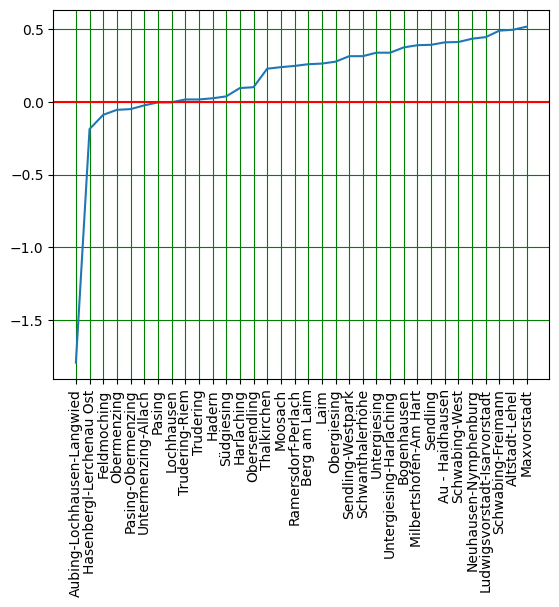

In [130]:
plt.plot(scores_df.index, scores_df['score'])
plt.xticks(rotation=90)
plt.axhline(y=0, color='r', linestyle='-')
plt.ayhline(y=0, color='r', linestyle='-')
plt.grid(c='')


plt.show()

In [118]:
print(f"mean = {np.mean(district_score_means)}")
print(f"min = {np.min(district_score_means)}")
print(f"max = {np.max(district_score_means)}")

mean = 0.1558657310216154
min = -1.7934078391165742
max = 0.5188621267240686


In [62]:
y_test

26280    2.0
26281    0.0
26282    0.0
26283    0.0
26284    0.0
        ... 
35035    4.0
35036    5.0
35037    1.0
35038    3.0
35039    3.0
Name: Maxvorstadt, Length: 8760, dtype: float64

In [ ]:
# Prediction for 2024-02-01 12:00
X_new # Weather prediction data for 2024-02-01 12:00
rent_date_hour_new # pick date_time for prediction
y_new = model.predict(X_new)


def bike_demand_predict(X_new, rent_date_hour):
    y_new = [] # List of rent_number for each district
    for district in districts:
        model.predict()

In [59]:
scores

[0.5281543776462376, 0.4874392592323423, 0.549115990806111, 0.5107388792115835]

In [52]:
# model = LinearRegression()
# scores = []
# indices = [0, 1, 2, 3]

# test_df = fold_dfs[0]
# train_folds = [fold_dfs[i] for i in indices if i != 0]
# train_df = pd.concat(train_folds, axis=0)
# X_test = test_df.drop(columns= districts)
# y_test = test_df['Maxvorstadt']
# X_train = train_df.drop(columns= districts)
# y_train = train_df['Maxvorstadt']


In [53]:
model.fit(X_train, y_train)
scores.append(model.score(X_test, y_test))

In [54]:
scores

[0.5281543776462376]